# **ARAM Patch Analysis**

## Load Libraries

In [1]:
import psycopg2 
import pandas as pd
import numpy as np;
import matplotlib.pyplot as plt
import seaborn as sns

# Set display option to show all columns
pd.set_option('display.max_columns', None)

# Code to ignore warnings from function usage
import warnings;
warnings.filterwarnings('ignore')


import ipywidgets as widgets
from IPython.display import display, clear_output

## Load Data

In [2]:
# Establish a connection to the PostgreSQL database
try:
    # Establish a connection to the PostgreSQL database
    connection = psycopg2.connect(
        host='localhost',
        database='leagueoflegendsapidata',
        user='postgres',
        password='naruto789',
        port=5432
    )
    print("Connected to the database")

    # Join the tables and retrieve data
    query = """
    SELECT pm.*, p.summoner_name, m.*
    FROM playerMatches AS pm
    JOIN player AS p ON pm.puuid = p.puuid
    JOIN matches AS m ON pm.match_id = m.match_id;
    """

    # Create a DataFrame from the query result
    dataframe = pd.read_sql_query(query, connection)

    # Close the database connection
    connection.close()
    print("Connection closed")

except psycopg2.Error as e:
    print("Error connecting to the database:", e)

Connected to the database
Connection closed


## Data Preprocessing

In [39]:
df = dataframe.copy()

In [40]:
# Convert game duration to minutes
df['game_duration_minutes'] = df['game_duration'] / 60

In [41]:
# Convert the 'participants' column to a DataFrame
participants_df = df['participants'].apply(pd.Series)

# Concatenate the new participant columns to the original DataFrame
df = pd.concat([df, participants_df], axis=1)

# Drop the original 'participants' column
df.drop(columns=['participants'], inplace=True)

In [42]:
# Standardize the summonerName column to lowercase
df['summoner_name'] = df['summoner_name'].str.lower()

In [43]:
# Remove duplicate columns pandas DataFrame
df = df.loc[:,~df.columns.duplicated()]

In [8]:
df.head()

,puuid,match_id,assists,baronkills,bountylevel,champexperience,champlevel,championid,championname,championtransform,consumablespurchased,damagedealttobuildings,damagedealttoobjectives,damagedealttoturrets,damageselfmitigated,deaths,detectorwardsplaced,doublekills,dragonkills,firstbloodassist,firstbloodkill,firsttowerassist,firsttowerkill,gameendedinearlysurrender,gameendedinsurrender,goldearned,goldspent,individualposition,inhibitorkills,inhibitortakedowns,inhibitorslost,item0,item1,item2,item3,item4,item5,item6,itemspurchased,killingsprees,kills,lane,largestcriticalstrike,largestkillingspree,largestmultikill,longesttimespentliving,magicdamagedealt,magicdamagedealttochampions,magicdamagetaken,neutralminionskilled,nexuskills,nexustakedowns,nexuslost,objectivesstolen,objectivesstolenassists,participantid,pentakills,physicaldamagedealt,physicaldamagedealttochampions,physicaldamagetaken,profileicon,quadrakills,riotidname,riotidtagline,champion_role,sightwardsboughtingame,spell1casts,spell2casts,spell3casts,spell4casts,summoner1casts,summoner1id,summoner2casts,summoner2id,summonerid,summonerlevel,summonername,teamearlysurrendered,teamid,teamposition,timeccingothers,timeplayed,totaldamagedealt,totaldamagedealttochampions,totaldamageshieldedonteammates,totaldamagetaken,totalheal,totalhealsonteammates,totalminionskilled,totaltimeccdealt,totaltimespentdead,totalunitshealed,triplekills,truedamagedealt,truedamagedealttochampions,truedamagetaken,turretkills,turrettakedowns,turretslost,unrealkills,visionscore,visionwardsboughtingame,wardskilled,wardsplaced,win,summoner_name,dataversion,game_creation,game_duration,game_end_time_stamp,game_id,game_mode,game_name,game_start_time_stamp,game_type,game_version,map_id,platform_id,queue_id,winning_team_id,losing_team_id,game_duration_minutes,0,1,2,3,4,5,6,7,8,9
0,rlZ-vd9xYGDcX8EqFWs7mgkoLuZWtJBbxsEf02KsXPOwz-...,NA1_4760729433,19,0,0,19507,18,166,Akshan,False,1,1745,1745,1745,25729,12,0,1,0,False,False,False,False,False,False,17153,14900,Invalid,0,1,2,3006,6672,6671,3087,3036,1053,0,25,5,16,TOP,592,3,3,166,35016,9279,11961,0,0,0,1,0,0,1,0,102666,42157,17264,3505,0,,,SUPPORT,0,98,23,141,7,6,6,5,4,u_ylSxPRpxkRLkVtTjDD8n6fta2L9uy9EIiJrObPIXR_gCM,693,drpygmr24,False,100,,0,1309,140411,51657,0,29819,6141,0,101,50,310,1,1,2728,220,593,0,2,4,0,0,0,0,0,False,drpygmr24,2,1693466392081,1309,2023-08-31 00:41:55.354000,4760729433,ARAM,teambuilder-match-4760729433,2023-08-31 00:20:06.010000,MATCHED_GAME,13.17.528.2266,12,NA1,450,200,100,21.816667,rlZ-vd9xYGDcX8EqFWs7mgkoLuZWtJBbxsEf02KsXPOwz-...,rcFMXyNZGycZdpLKJCiIetfSWxY2Jre0ZHE8Vm7QDiaXME...,bApe9H2PKXqDF3SsVE05nPPXvtXSl__mJtaeRSnoBlfp8T...,-y-0vBxzTXpODyB5b1SYcVntEo6BWkIDUZCTq8sgtaNsRY...,O2Aa5wETgswu6Yc3bL4Yjo-FYth0TFBkldTl6rsF3NRhqb...,YbTdEDPP2e51WGe5rhmKBNpg4bgO3EqicQvnFtyvh95PAS...,ZuW2zc8tdPA1eqEPL-Y0kOeIW7MKwfDn5cjw8fggoSoM3K...,Wfv940r_STdJCo82l-Iws4Muawu2F3xDm27YsJLTT0K7_7...,70EwUe_T1mjPkmzFDMqPYFUb2psbkHXq37n67VCqdWL9Pl...,MJf-LVgc9_k8sM4hIzz9vgQXSgypTxTmO44j_HeTEhlcUH...
1,-aUdgZDOBST6wwQhOqzh5xPP8wNIJoC5m5kUK62JLCQ8lv...,NA1_4766122319,3,0,0,3576,7,31,Chogath,False,0,2720,2720,2720,877,0,0,0,0,True,False,False,True,False,False,3838,1300,Invalid,0,1,0,1011,1028,0,0,0,0,2052,2,0,0,NONE,0,0,0,0,4710,619,87,0,0,1,0,0,0,9,0,1865,50,1749,4149,0,,,SUPPORT,0,8,4,7,1,7,32,1,4,nuwo9oCOXO_PA1-eQzNoO1ZOn7-1_krx7I9I58ib9B4G0-8,298,Yofriend,False,200,,7,277,7966,732,0,1897,320,0,5,51,0,1,0,1390,62,60,1,4,0,0,0,0,0,0,True,yofriend,2,1694034524540,277,2023-09-06 14:14:03.983000,4766122319,ARAM,teambuilder-match-4766122319,2023-09-06 14:09:26.841000,MATCHED_GAME,13.17.529.525,12,NA1,450,200,100,4.616667,mwhkzm99rCu6AasO-dSx395hxsgLL58gRSg9chs_O815x4...,ROIHW316A5Wao_JDuw9uJbp462rL-1o8P4Cmu7vrsUDy8w...,rRQMrc81jbzyTWNsyuzLRWI75vkv7-Cif-LQid_k_8REzu...,l2IOldg7bWmtZCfV3Wxq6U5kUV48aPr4qJXNByJNIqiZb5...,3LqVPv6TacuV2VnymmwfxksYuGOsuKIUFhtjGLbhiRM94c...,iOsdh90ASbrZ7e-d-vCUHvc4n1g4_-So6LfNAP-O-qkVd5...,UuUSZdmya3xacHWU3W4-I-zo6xYXxiCzEf6H9NNqDMfY5M...,O2Aa5wETgswu6

## Data Analysis

In [8]:
win_rate_df = df.groupby(['game_version', 'championname'])['win'].mean().reset_index()

In [13]:
df['game_version'].value_counts(1)*100

13.16.525.6443    11.898393
13.17.529.525      8.852570
13.10.509.8402     6.826733
13.15.524.1760     6.174289
13.9.506.4846      6.169940
                    ...    
12.6.431.7988      0.004350
12.16.461.7002     0.004350
11.20.400.7328     0.004350
13.13.517.6152     0.003262
12.3.420.4308      0.002175
Name: game_version, Length: 78, dtype: float64

In [24]:
def print_unique_champion_win_rates_for_patch(df, patch_version):
    # Filter the DataFrame for the specified patch version
    patch_df = df[df['game_version'] == patch_version]
    
    if patch_df.empty:
        print(f"No data found for Patch {patch_version}")
        return

    # Calculate the champion win rates as percentages
    patch_df['winrate_percent'] = patch_df['win'] * 100

    # Group by champion name and calculate the mean win rate
    result_df = patch_df.groupby('championname')['winrate_percent'].mean().reset_index()
    
    # Sort the DataFrame by win rate in descending order
    result_df = result_df.sort_values(by='winrate_percent', ascending=False)
    
    # Print the result as a table
    print(result_df)

In [25]:
print_unique_champion_win_rates_for_patch(df, '13.17.529.525')

    championname  winrate_percent
44         Ivern        58.303887
45         Janna        58.241758
73      Malphite        57.181943
33         Galio        56.962025
134   Tryndamere        56.923077
..           ...              ...
24       DrMundo        43.798450
105       Rengar        42.638037
2          Akali        42.446043
40       Hecarim        42.152466
91          Olaf        41.441441

[164 rows x 2 columns]


In [51]:
# Function to convert version string to a sortable tuple of integers
def version_to_tuple(version):
    version_parts = version.split('.')
    version_ints = [int(part) for part in version_parts]
    return tuple(version_ints)

# Apply the function to create an 'version_tuple' column
df['version_tuple'] = df['game_version'].apply(version_to_tuple)

# Sort the DataFrame by the 'version_tuple' column in ascending order
df = df.sort_values(by='version_tuple')

In [67]:
def update_plot(patch_version):
    clear_output(wait=True)
    patch_df = df[df['game_version'] == patch_version]
    
    if patch_df.empty:
        print(f"No data found for Patch {patch_version}")
        return

    # Calculate the win rate for each champion
    patch_df['win_rate'] = patch_df.groupby('championname')['win'].transform('mean')
    
    # Sort the DataFrame by win rate in descending order
    patch_df = patch_df.sort_values(by='win_rate', ascending=False)
    
    plt.figure(figsize=(20, 35))
    ax = sns.barplot(x='win_rate', y='championname', data=patch_df, palette='viridis', ci=None)
    
    plt.title(f'Win Rates for Champions in Patch {patch_version}')
    plt.xlabel('Win Rate')
    plt.ylabel('Champion')
    plt.xlim(0, 1)  # Set the x-axis limits to 0-100%
    plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])  # Set x-axis ticks
    plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
    plt.show()

def plot_win_rates_interactive(df):
    # Get unique game versions
    game_versions = df['game_version'].unique()
    
    # Create a dropdown widget for patch selection
    patch_selector = widgets.Dropdown(
        options=game_versions,
        description='Patch Version:',
        disabled=False,
    )
    
    # Create a button to trigger the update
    update_button = widgets.Button(description="Update Plot")
    
    # Define an update function that uses the selected patch_version
    def update_plot_on_button_click(btn):
        update_plot(patch_selector.value)
        # Display the dropdown and button
        display(widgets.VBox([patch_selector, update_button]))
    
    # Attach the update function to the button click event
    update_button.on_click(update_plot_on_button_click)
    
    # Display the initial plot
    initial_patch_version = game_versions[0]
    update_plot(initial_patch_version)
    
    # Display the dropdown and button
    display(widgets.VBox([patch_selector, update_button]))

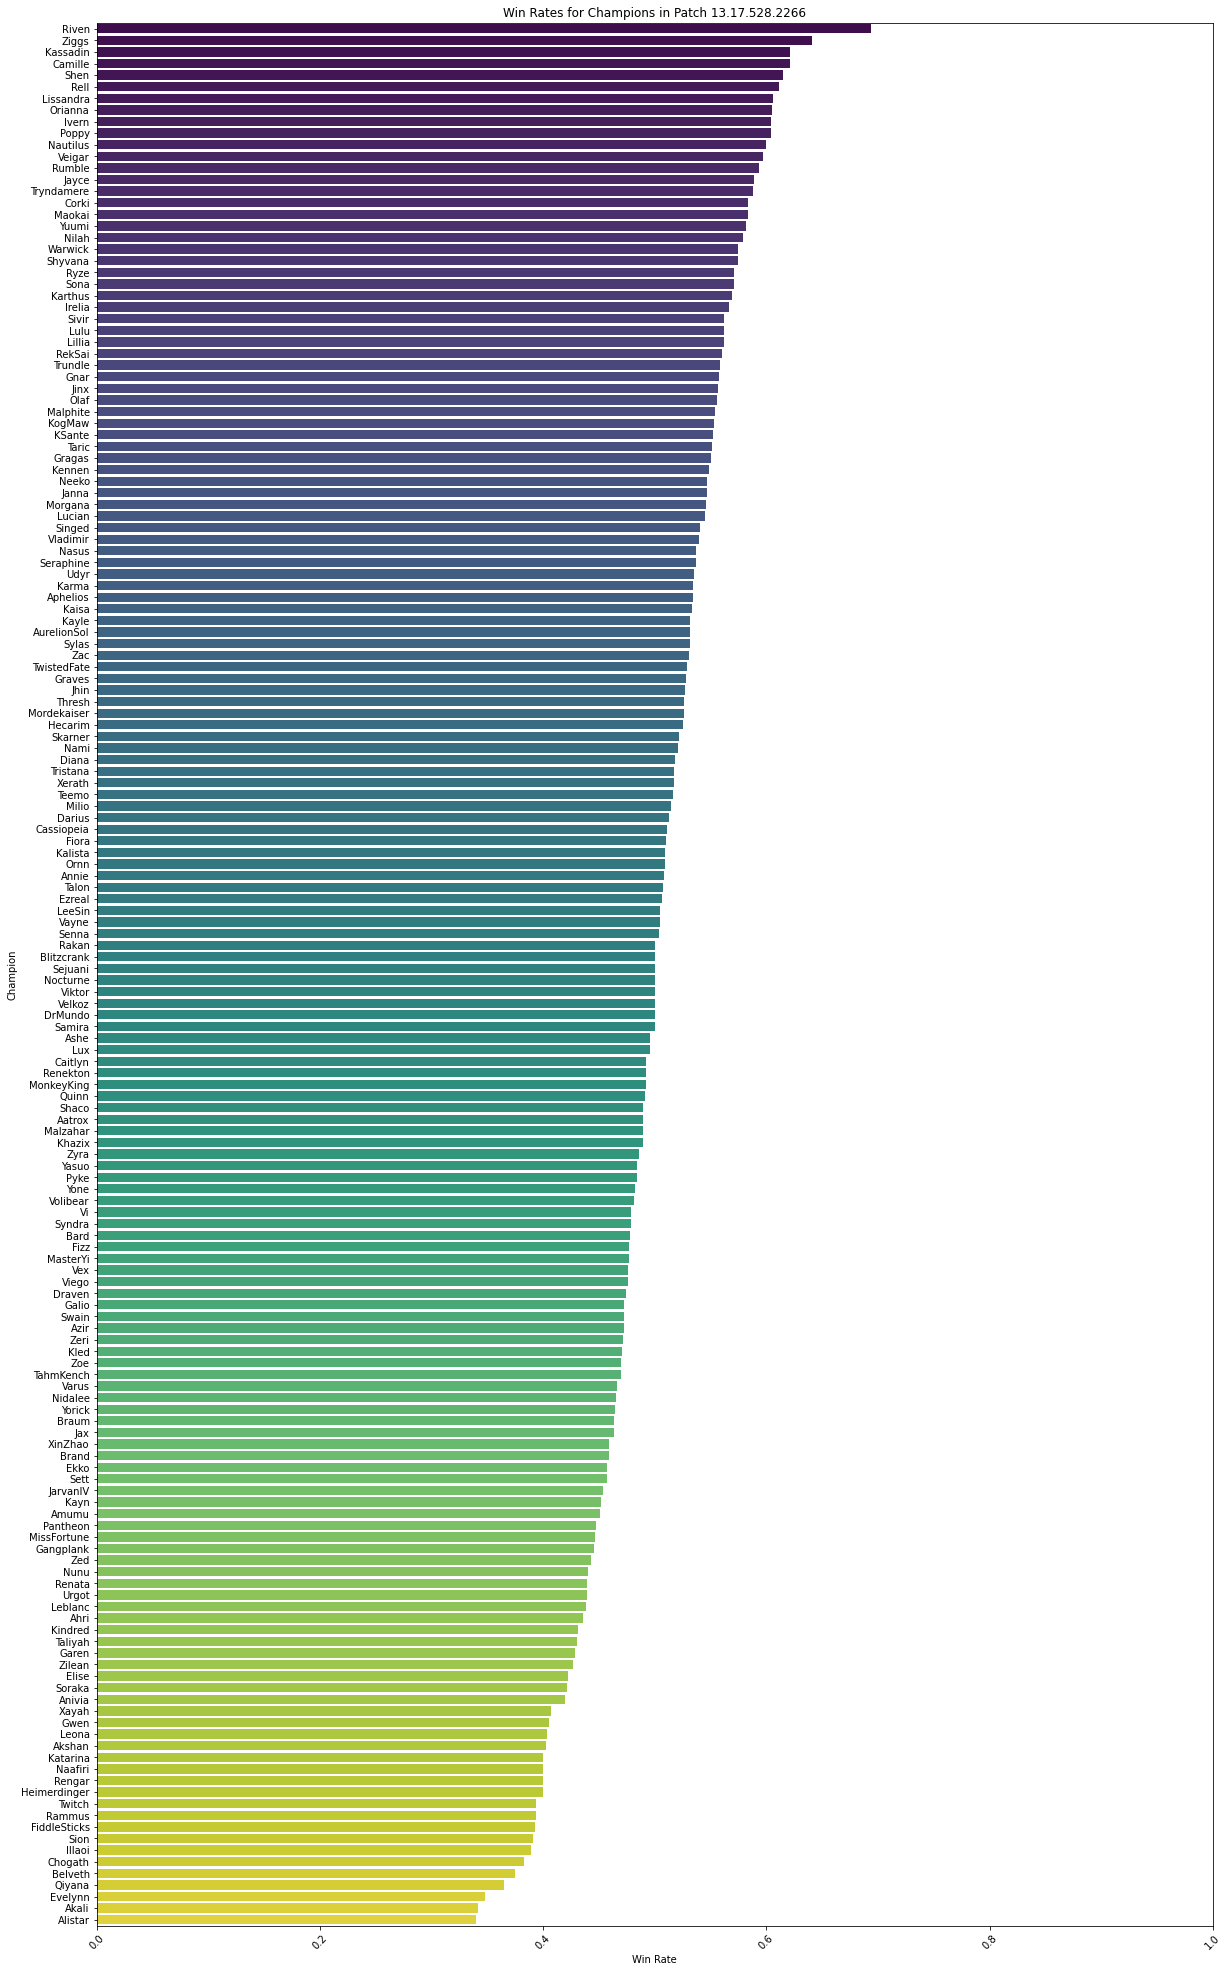

In [68]:
plot_win_rates_interactive(df)

In [54]:
# Function to update the champion win rate graph
def update_champion_win_rate(champion_name):
    champion_df = df[df['championname'] == champion_name]

    if champion_df.empty:
        print(f"No data found for {champion_name}")
        return

    # Sort the champion_df based on the 'version_tuple' column
    champion_df = champion_df.sort_values(by='version_tuple')

    plt.figure(figsize=(20, 10))
    sns.lineplot(x='game_version', y='win', data=champion_df, marker='o')
    plt.title(f'Win Rate Over Patches - {champion_name}')
    plt.xlabel('Patch Version')
    plt.ylabel('Win Rate')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

# Function to create the interactive champion win rate graph
def create_champion_win_rate_interactive(df):
    # Get unique champion names
    champion_names = df['championname'].unique()

    # Create a dropdown widget for champion selection
    champion_selector = widgets.Dropdown(
        options=champion_names,
        description='Champion:',
        disabled=False,
    )

    # Create a button to trigger the update
    update_button = widgets.Button(description="Update Plot")
    
    # Define an update function that uses the selected champion_name
    def update_plot_on_button_click(btn):
        update_champion_win_rate(champion_selector.value)
    
    # Attach the update function to the button click event
    update_button.on_click(update_plot_on_button_click)
    
    # Display the initial widget
    initial_champion_name = champion_names[0]
    display(widgets.VBox([champion_selector, update_button]))
    
    # Display an output area for the graph
    output_area = widgets.Output()
    display(output_area)
    with output_area:
        update_champion_win_rate(initial_champion_name)


Output()

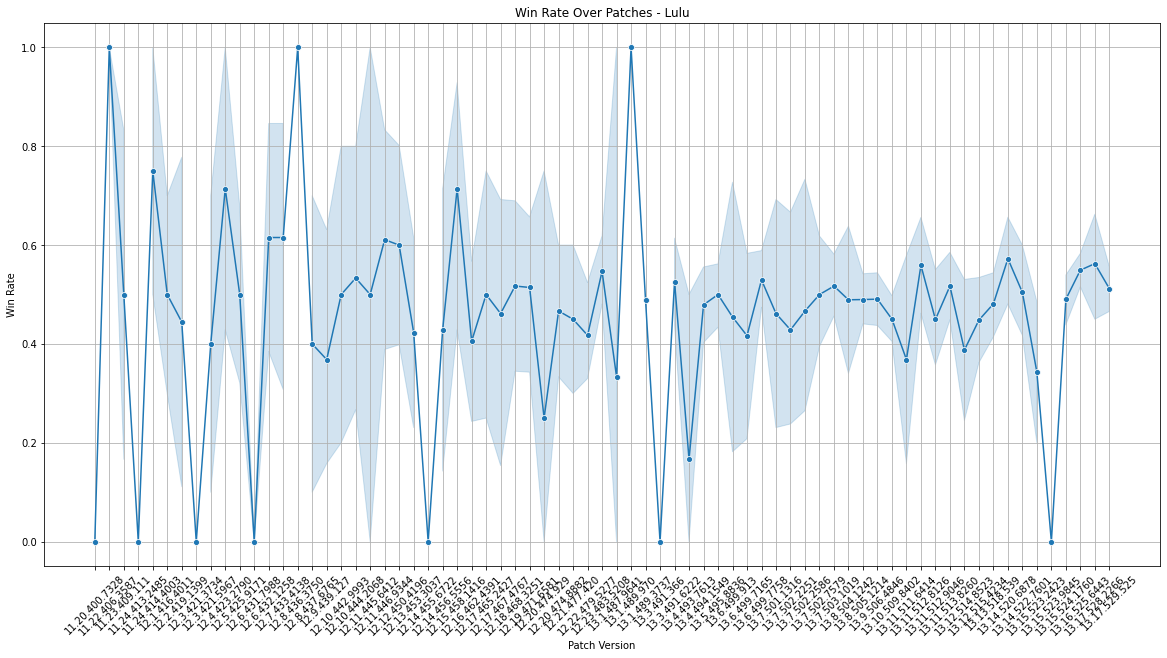

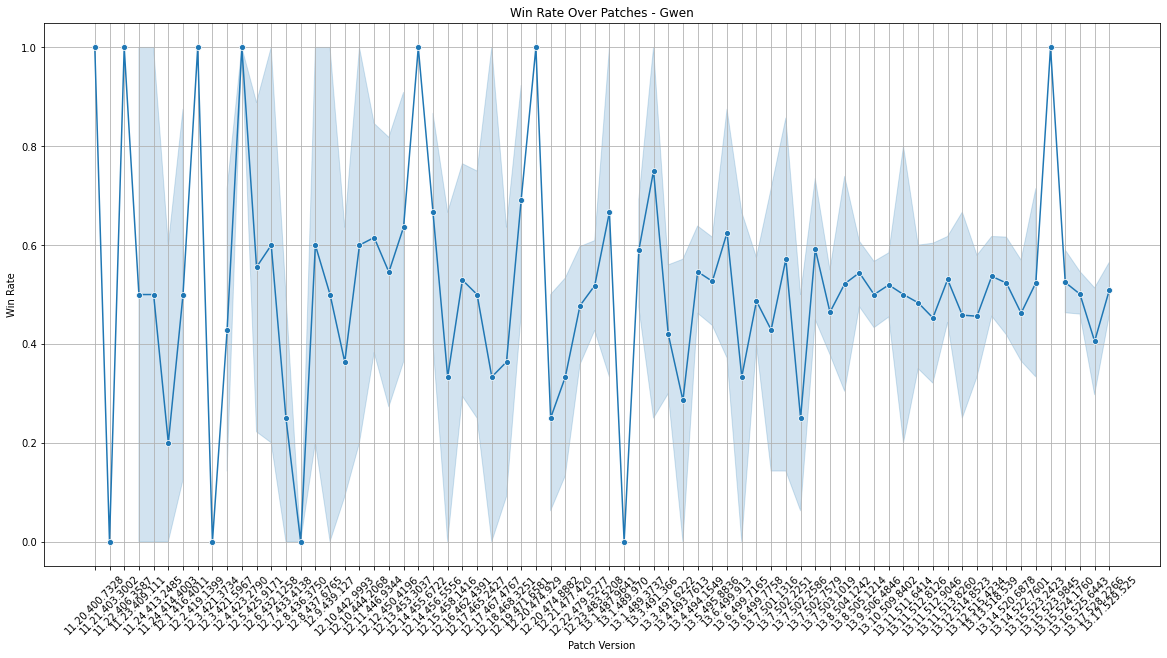

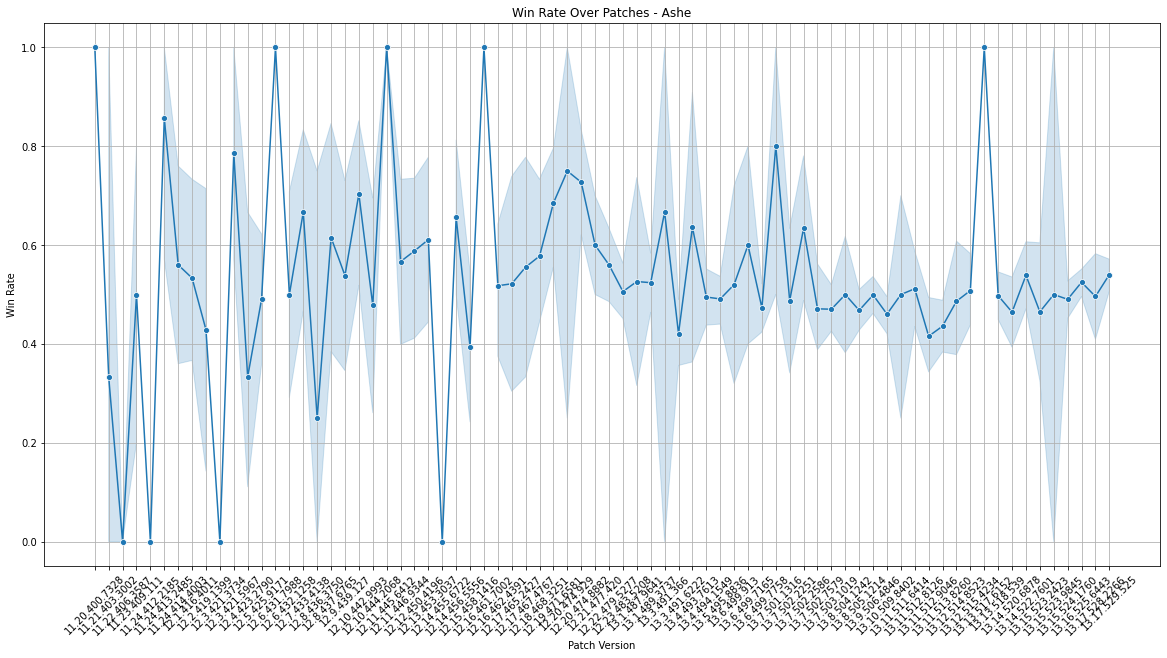

In [55]:
create_champion_win_rate_interactive(df)